# Data Preparation

### Problemi
- Le immagini sono molto pesanti (2000x2000)
- Se ridimensionassi avrei perdita di informazione e dettaglio
- Se estraessi le features, come ricostruirei il frame nel futuro?

### Passaggi:
- Eliminazione dati nulli/outliers
- Feature engineering/riduzione dimensionalitá
    - Resize semplice (lossy)
    - PCA 
        (PROBLEMA ricostruzione)
    - Autoencoder per rappresentazione compressa
        - https://paperswithcode.com/paper/an-end-to-end-compression-framework-based-on
    - Variabili selezionate da Random Forest 
        (PROBLEMA ricostruzione)
    - Correlazione con l'output (matrice successiva)
- Trasformazione dei valori (normalizzazione/standardizzazione)

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

### Data Import

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    data = np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)
    
    data[data > 100] = 0
    
    return data

In [3]:
def get_time_step(root, index):
    
    dep = txt_to_matrix(root + 'decoded-' + index + '.DEP')
    vvx = txt_to_matrix(root + 'decoded-' + index + '.VVX')
    vvy = txt_to_matrix(root + 'decoded-' + index + '.VVY')

    return np.array([dep, vvx, vvy])

def get_dep_time_step(root, index):
    
    dep = txt_to_matrix(root + 'mini-decoded-' + index + '.DEP')

    return np.array([dep])

In [4]:
rootdir = '../datasets/530-9m1s/'
timesteps = []
ignore = [".DS_Store", ".", ".."]

x = 0
offset = 0
ceiling = 530

# Read all dirs and process them
for path in tqdm.tqdm(range(ceiling - offset)):
    
    # Processing
    file = rootdir
    timesteps.append(
        get_dep_time_step(
            file, ("{:04d}".format(x + offset))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)

100%|██████████| 530/530 [00:57<00:00,  9.26it/s]


### Data preprocessing

In [6]:
# Rimozione valori estremi
threshold = 10
timesteps[timesteps > threshold] = 0

### Scikit PCA
Problemi PCA: come ritornare al frame ricostruito?

In [7]:
X = np.asarray([t.flatten() for t in timesteps[:, 0]])
print("Data of shape: {}".format(X.shape))

Data of shape: (530, 114576)


In [8]:
from sklearn.decomposition import PCA

compression = 100
components = min(X.shape)

# create the PCA instance
pca = PCA(components)
# fit on data
pca.fit(X)

# print(pca.components_)
# print(pca.explained_variance_)

# transform data
B = pca.transform(X)

print(B.shape)

(530,)


#### Compressione con autoencoder

In [9]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.encoder_in = nn.Linear(input_shape, 2048)
        self.encoder_h1 = nn.Linear(2048, 2048)
        
        self.decoder_in = nn.Linear(2048, 2048)
        self.decoder_out = nn.Linear(2048, input_shape)

    def forward(self, x):
        
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        
        x = torch.relu(self.decoder_in(x))
        x = torch.relu(self.decoder_out(x))
        return x
    
    def get_compressed(self, x):
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        return x

In [10]:
flattened_img = timesteps[0, 0].flatten().shape[0]
autoencoder = AE(input_shape=flattened_img)

In [11]:
epochs = 1

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_size = int(timesteps.shape[0] * 0.7)
train_set = timesteps[:train_size]

for epoch in range(epochs):
    loss = 0
    
    print("epoch {}".format(epoch))
    for index in tqdm.tqdm(range(train_set.shape[0])):        
        
        optimizer.zero_grad()
        
        picture = train_set[index, 0]
        picture = torch.Tensor(picture.flatten())
        
        Y_hat = autoencoder(picture)
        
        train_loss = criterion(Y_hat, picture)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    print("Avg epoch loss: {}".format(loss/timesteps.shape[0]))

  0%|          | 0/371 [00:00<?, ?it/s]

epoch 0


  0%|          | 0/371 [00:00<?, ?it/s]

Avg epoch loss: 0.001596910427940871
epoch 1


  0%|          | 0/371 [00:02<?, ?it/s]


KeyboardInterrupt: 

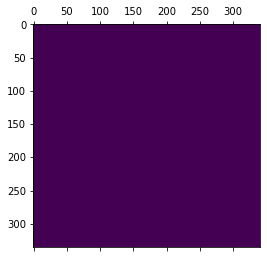

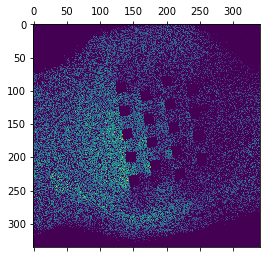

In [13]:
test_set = timesteps[train_size:]

test_raw = train_set[10, 0]
test = torch.Tensor(test_raw.flatten())
shp = test_set[5, 0].shape

compressed = autoencoder.get_compressed(test)
img = autoencoder(torch.Tensor(test))

img = img.detach().numpy()

# Plot
#plt.title("Original")
plt.matshow(test_raw)

#plt.title("Reconstructed")
plt.matshow(img.reshape(shp[0], shp[1]))